# AI for Earth System Science Hackathon 2020
# GOES Challenge
David John Gagne, Gunther Wallach, Charlie Becker, Bill Petzke

## Introduction
![GOES-R satellite image from Wikipedia](goes_images/GOES-R_SPACECRAFT.jpg)

Lightning kills roughly 30 people per year in the United States (https://www.weather.gov/safety/lightning-victims) and can have large economic impacts by disrupting outdoor work and events and by sparking fires. Improved short term prediction of lightning onset can help protect life and property by ensuring that people can get to safety with sufficient lead time. The economic impacts of lightning protection practices can also be reduced by improving the prediction of when lightning is expected to end. 

Recently deployed observational systems combined with advances in machine learning have the potential to improve the short-term prediction of lightning by associating broader scale weather patterns with the future occurrence of lightning in that area. The Geostationary Operational Environmental Satellite 16 (GOES-16) is a weather satellite that orbits the Earth at a fixed point situated along the same longitude as the Eastern United States and can provide a hemispheric, multispectral view of cloud patterns at high space and time resolution through its Advanced Baseline Imager (ABI) camera. The satellite also holds the Geostationary Lightning Mapper (GLM) instrument that records lightning flashes across the hemispheric view of the satellite. By combining the data collected by these two instruments, we can develop new machine learning solutions to the challenge of short range lightning prediction.  

## Software Requirements
This notebook requires Python >= 3.7. The following libraries are required:
* numpy
* scipy
* matplotlib
* xarray
* pandas
* scikit-learn
* tensorflow >= 2.1
* netcdf4
* tqdm


In [1]:
! pip install numpy scipy matplotlib xarray pandas netcdf4 h5netcdf tqdm tensorflow scikit-learn dask s3fs goes16ci seaborn

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import random
import xarray as xr
import tensorflow as tf
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster, progress
from goes16ci.models import StandardConvNet, ResNet, MinMaxScaler2D
from sklearn.preprocessing import StandardScaler
import s3fs
from glob import glob
%matplotlib inline

# Set random seed
seed = 3985
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Data

### Data Generation


There are several GOES-16 data products available. We are primarily interested in the water vapor bands from the Advanced Baseline Imager (ABI) and lightning counts from the Geostationary Lightning Mapper (GLM). The ABI camera’s spatial resolution is 2 km with a temporal resolution of 5 minutes. We chose to select/crop 32 x 32 sized image patches (for each band) across our domain (CONUS Midwest) at an upsampled rate of every 20 minutes from 2019-03-02 through 2019-10-01. We used these same spatio-temporal patches to aggregate all lightning flash counts within that patch but lagged by one hour. Total aggregated data was output at a daily interval.  

### Useful Links

[Overall GOES-16 Band Reference Guide](https://www.weather.gov/media/crp/GOES_16_Guides_FINALBIS.pdf)

[GOES-16 Band 08 Info (Upper-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band08.pdf)

[GOES-16 Band 09 Info (Mid-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band09.pdf)

[GOES-16 Band 10 Info (Low-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band10.pdf)

[GOES-16 Band 14 Info (Longwave Window)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band14.pdf)

[GOES-16 Geostationary Lightning Mapper (GLM)](https://www.goes-r.gov/spacesegment/glm.html)


### Time span of the dataset

|  | Date/Time | 
| ------------- | :---- |
| Start | 2019-03-02 00:20:00 | 
| End | 2019-10-02 00:00:00 |
| Timestep | 00:20:00 | 
| NOTE: some days are missing (intentionally skipped) to isolate convective cycles





### Geographic Coverage of Dataset (Mostly Midwest CONUS)

|  | Latitude | Longitude |
| ------------- | :----:|:- |
| Min | 29.09 | -97.77 |
| Max | 48.97 | -82.53 |




### Dimensions

| Dimension Name | Description | Size |
| ------------- | :----:|:----------- |
| Band     | ABI Band Number  | 4 (Bands 8,9,10,14) |
| Patch      | spatio-temporal patch | ~3600 per day |
| X      | X-plane | 32 |
| Y      | Y-plane | 32 |

### Potential Input Variables

| Variable Name | Units | Description | 
| ------------- | :----:|:----------- | 
| abi (Band 08)   | K     | Upper-level Water Vapor | 
| abi (Band 09)   | K     | Mid-level Water Vapor   |
| abi (Band 10)   | K     | Lower-level Water Vapor |
| abi (Band 14)   | K     | Longwave Window         |

### Output Variables

| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| flash_counts    | -     | Lightning strike count |


### Metadata Variables

| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| Time     | YYYY-MM-DDTHH:MM:SS  | The Date   |
| Lat      | Degrees     | Latitude   |
| Lon      | Degrees     | Longitude  |


### Training/Validation/Testing Sets

The function `split_data_files()` will split the data files into approximately equal partitions for training/validation/testing. By default, it takes 4-day contiguous data “chunks” per partition while skipping 1 day between to isolate convective cycles (and thus not validate/test on data linked to the training data), and repeats throughout the selected timespan.  Thus, each set should contain approximately 210,000 (32 x 32)  samples (patches) if the entire timespan is used.


In [3]:
# How to load the data from disk or cloud

def split_data_files(dir_path="ncar-aiml-data-commons/goes/ABI_patches_32/", file_prefix='abi_patches_', 
               start_date='20190302', end_date='20191001', seq_len=4, skip_len=1):
    """
    Take daily ABI patch files and split into equal training/validation/testing
    semi-contiguous partitions, skipping day(s) between chunks to isolate convective 
    cycles.
    
    Args: 
        dir_path: (str) Directory path to daily ABI files
        file_prefix: (str) File prefix up to date 
        start_date: (str) Starting date to get files in format of YYYYMMDD
        end_date: (str) Ending date to get files in format of YYYYMMDD
        seq_len: (int) Length of days per 'chunk' of data
        skip_len: (int) How many days to skip between data chunks
        
    Returns:
        train_f, val_f, test_f: list of training/validation/test files
    """
    
    all_files = fs.ls(dir_path)
    start_index = all_files.index('{}{}{}T000000.nc'.format(dir_path, file_prefix, start_date))
    end_index = all_files.index('{}{}{}T000000.nc'.format(dir_path, file_prefix, end_date))
    file_spread = all_files[start_index:end_index+1]
    
    train_files, val_files, test_files = [], [], []
    
    for i in np.arange(0, len(file_spread)+1, (seq_len+skip_len)*3):
        
        val_i = i + seq_len + skip_len
        test_i = i + (seq_len + skip_len)*2
        
        train_files.append(file_spread[i:i+seq_len])
        val_files.append(file_spread[val_i:val_i+seq_len])
        test_files.append(file_spread[test_i:test_i+seq_len])
        
    train_f = [item for sublist in train_files for item in sublist]
    val_f = [item for sublist in val_files for item in sublist]
    test_f = [item for sublist in test_files for item in sublist]
    
    return train_f, val_f, test_f

def fetch_data(file_number, file_list):
    """
    Function to be distributed across a cluster to individually load files directly from an AWS S3 bucket 
    
    Args:
        file_number: index for file from file_list
        file_list: List of files to index from
    Returns:
        ds: xarray dataset of daily file 
    """
    obj = fs.open(file_list[file_number])
    ds = xr.open_dataset(obj, chunks={})
    
    return ds

def merge_data(file_list):
    """
    Take a list of files and distribute across a cluster to be loaded then gathered and concantenated
    
    Args:
        file_list: List of files to be merged together (training, validation, or testing)
    Returns:
        merged_data: Concatenated xarray dataset of training, validation, or testing data 
    """
    futures = client.map(fetch_data, range(len(file_list)), [file_list]*len(file_list))
    results = client.gather(futures)
    merged_data = xr.concat(results, 'patch').compute()
    #merged_data.to_netcdf('local_dataset.nc')
    return merged_data

def prepare_data(data):
    """
    Take GOES netCDF data, filter out NaNs, reshape for tensorflow, convert flash_counts to binary,
    and return filtered numpy arrays
    Args:
        data: GOES patch netCDF data including ABI bands and lightning flash counts
    Returns:
        good_imagery: NaN filtered numpy array with reshaped dimensions (patch, x, y, band)
        binary_output: 1D numpy array of lightnin flash_counts
    """
    
    input_data = np.moveaxis(data['abi'].values, 1, -1)
    output_data = data['flash_counts'].values
    
    nan_indices = np.unique(np.where(np.isnan(input_data))[0])
    all_indices = np.arange(input_data.shape[0])
    valid_indices = all_indices[np.isin(all_indices, nan_indices, assume_unique=True, invert=True)]
    
    good_imagery = input_data[valid_indices]
    binary_output = np.where(output_data > 0, 1, 0)[valid_indices]
    
    return good_imagery, binary_output

We use DASK to create a local cluster to speed up the data loading process (Loading data directly from an AWS S3 bucket can be slow).

In [4]:
cluster = LocalCluster(processes=True, threads_per_worker=2)
client = Client(cluster)
fs = s3fs.S3FileSystem(anon=True)

In [5]:
%%time
# Split into training, validation, and test sets
if os.path.isfile('./train_data.nc') and os.path.isfile('./train_data.nc') and os.path.isfile('./test_data.nc'):
    train = xr.open_dataset('./train_data.nc')
    val = xr.open_dataset('./val_data.nc')
    test = xr.open_dataset('./test_data.nc')
else:
    # We only load the train and val sets here to save a couple minutes
    train_files, val_files, test_files = split_data_files()
    train, val, test = map(merge_data, [train_files, val_files, test_files])
    train.to_netcdf('./train_data.nc')
    val.to_netcdf('./val_data.nc')
    test.to_netcdf('./test_data.nc')

CPU times: user 42.4 ms, sys: 10.6 ms, total: 53.1 ms
Wall time: 135 ms


In [6]:
client.shutdown()

## Exploratory visualizations

When seperating by band, lightning active patches usually have a similar brightness temperature (BT) profiles throughout the 4 water vapor channels. Low BT convective cells are often seen as well (as expected).

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


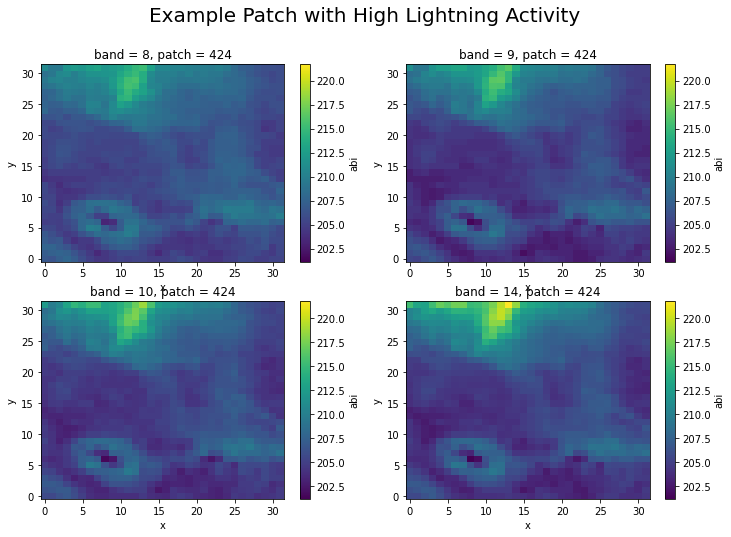

In [7]:
high_lc_indices = np.argwhere(train.flash_counts.values > 100).flatten() # indices with more than 100 lightning counts
no_lc_indices = np.argwhere(train.flash_counts.values == 0).flatten() # indices with no lightning counts

index = high_lc_indices[205]
vmin = train['abi'][index,:,:,:].min() # set min/max plotting range  
vmax = train['abi'][index,:,:,:].max()

fig, ax = plt.subplots(2,2, figsize=(12,8))
for i in range(4):
    train['abi'][index,i,:,:].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
    plt.suptitle('Example Patch with High Lightning Activity', fontsize=20)

Areas without lightning activity often exibit a much larger BT range throughout the channel column, particularily the longwave window (Band 14) which often has much higher values with clear skies.

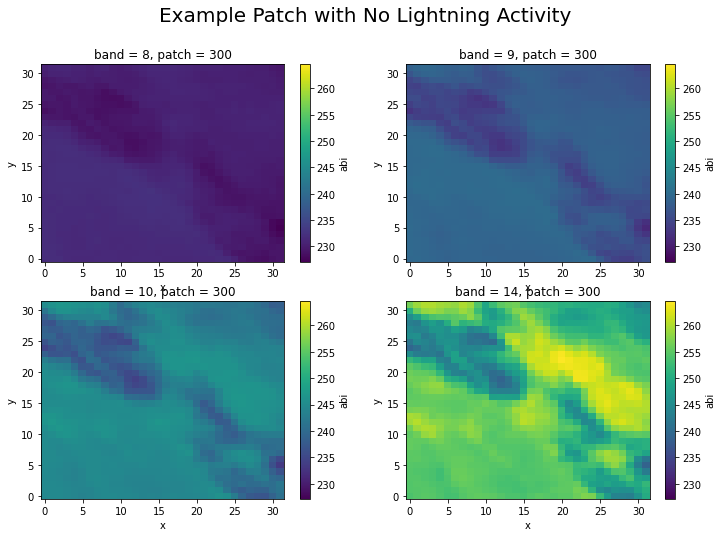

In [50]:
index = no_lc_indices[300]
vmin = train['abi'][index,:,:,:].min() # set min/max plotting range
vmax = train['abi'][index,:,:,:].max() # set min/max plotting range

fig, ax = plt.subplots(2,2, figsize=(12,8))
for i in range(4):
    train['abi'][index,i,:,:].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
    plt.suptitle('Example Patch with No Lightning Activity', fontsize=20)

This pattern is also noted when taking the mean value of each patch across the dataset.

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


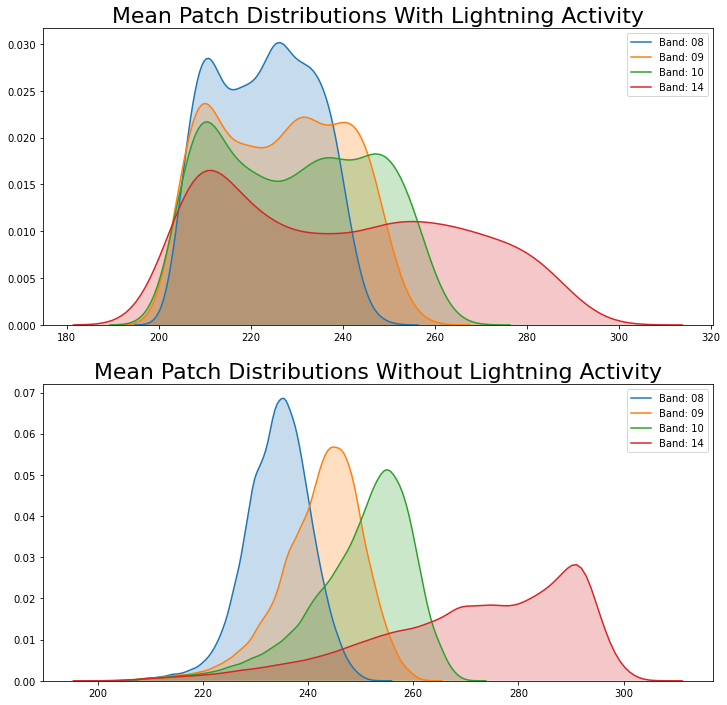

In [58]:
high_lc_indices = np.argwhere(train.flash_counts.values > 100).flatten() # indices with more than 100 lightning counts
no_lc_indices = np.argwhere(train.flash_counts.values == 0).flatten() # indices with no lightning counts

lc_train = train.isel(patch=high_lc_indices) # all patch data with lightning counts (above threshold)
no_lc_train = train.isel(patch=no_lc_indices) # all patch data without lightning activity
mean_patches_lc = lc_train.abi.mean(dim=('x','y')) # mean BT of each patch
mean_patches_no_lc = no_lc_train.abi.mean(dim=('x','y')) # mean BT of each patch

fig, ax = plt.subplots(2,1, figsize=(12,12))
for i,lab in enumerate(['Band: 08', 'Band: 09', 'Band: 10', 'Band: 14']*2):
    if i < 4:
        sns.kdeplot(mean_patches_lc[:,i], ax=ax[0], label=lab, shade=True).set_title(
            'Mean Patch Distributions With Lightning Activity', fontsize=22)
    else:
        sns.kdeplot(mean_patches_no_lc[:,i-4], ax=ax[1], label=lab, shade=True).set_title(
            'Mean Patch Distributions Without Lightning Activity', fontsize=22)

### Data Transforms
Discuss any transforms or normalizations that may be needed for this dataset. Remember to fit a scaler only to the training data and then apply it on testing and validation.

In [8]:
%%time
# get numpy arrays of patch data for each band (this also converts all flash_counts to binary classes)
train_in, train_out = prepare_data(train) 
val_in, val_out = prepare_data(val)

CPU times: user 1min 11s, sys: 4.21 s, total: 1min 15s
Wall time: 1min 27s


In [8]:
# scale data
scaler = MinMaxScaler2D()
scaled_train_in = scaler.fit_transform(train_in)
scaled_val_in = scaler.transform(val_in)

In [ ]:
# declare ResNet (residual network from the goes16i module) and list the default parameters
# Any of these parameters can be overridden
# note using larger batch sizes here can cause memory errors
resNet_mod = ResNet(epochs=5, batch_size=512)
vars(resNet_mod)

In [ ]:
%%time
# Fit model and print architecture
resNet_mod.fit(scaled_train_in, train_out, scaled_val_in, val_out)
resNet_mod.model.summary()

## Baseline ResNet Evaluation Metrics
We trained on binary output data, but output probabilities before converting to class. This allows us to evaluate regressed and classified metrics:


| Type | Metric | Value to beat |
| ------------- | :----:|:-------|
|  Regressed   ||   
|              | RMSE: |0.328|
|              | R2: |0.567 |
|              | Hellenger Distance: |0.501|
|||
| Classified   |||
|              | Heidke Skill Score: |0.705|
|              | Peirce Skill Score:  |0.713|
|              | Brier Score: |0.143|
|              | Brier Skill Score: |0.402|
|              | AUC: |0.856|

In [ ]:
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
preds = resNet_mod.predict(scaled_val_in).reshape(val_out.shape[0])
binary_preds = np.where(preds >= binary_threshold, 1, 0)

In [9]:
# Metric functions
from sklearn.metrics import confusion_matrix, mean_squared_error, brier_score_loss, roc_auc_score

import numpy as np

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def auc_score(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def brier_score(y_true, y_pred):
    return brier_score_loss(y_true, y_pred)

def brier_skill_score(y_true, y_pred):
    
    model_brier_score = mean_squared_error(y_true, y_pred)
    climo_brier_score = mean_squared_error(y_true, np.ones(y_true.size) * y_true.sum() / y_true.size)
    model_brier_skill_score = 1 - model_brier_score / climo_brier_score
    return model_brier_skill_score

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def peirce_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (no * no).sum() / n ** 2)

def heidke_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (nf * no).sum() / n ** 2)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

def perf_measure(y_true, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_true)): 
        if y_true[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_true[i]!=y_pred[i]:
           FN += 1
    # Sensitivity, hit rate, recall, or true positive rate, or probability of detection
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate or false alarm ratio
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    return {
        'TP'  : TP,
        'FP'  : FP,
        'TN'  : TN,
        'FN'  : FN,
        'TPR' : TPR,
        'TNR' : TNR,
        'PPV' : PPV,
        'NPV' : NPV,
        'FPR' : FPR,
        'FNR' : FNR,
        'FDR' : FDR,
        'ACC' : ACC,
        }
    

In [ ]:
# Example regressed metrics
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))

## Interpretation
Description of interpretation methods for problem

In [ ]:
# Include examples of interpretation code

## Hackathon Challenges

### Monday
* Load the data
* Create an exploratory visualization of the data
* Test two different transformation and scaling methods
* Test one dimensionality reduction method
* Train a linear model
* Train a decision tree ensemble method of your choice

In [ ]:
# First play with different thresholds for the binary classification - 0.25
binary_threshold = 0.25
preds = resNet_mod.predict(scaled_val_in).reshape(val_out.shape[0])
binary_preds = np.where(preds >= binary_threshold, 1, 0)

In [ ]:
# Example regressed metrics
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))

In [ ]:
# First play with different thresholds for the binary classification - 0.75
binary_threshold = 0.75
preds = resNet_mod.predict(scaled_val_in).reshape(val_out.shape[0])
binary_preds = np.where(preds >= binary_threshold, 1, 0)

In [ ]:
# Example regressed metrics
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))

In [ ]:
high_lc_indices = np.argwhere(train.flash_counts.values > 100).flatten() # indices with more than 100 lightning counts
no_lc_indices = np.argwhere(train.flash_counts.values == 0).flatten() # indices with no lightning counts

lc_train = train.isel(patch=high_lc_indices) # all patch data with lightning counts (above threshold)
no_lc_train = train.isel(patch=no_lc_indices) # all patch data without lightning activity

#standard deviation
std_patches_lc = lc_train.abi.std(dim=('x','y')) # mean BT of each patch
std_patches_no_lc = no_lc_train.abi.std(dim=('x','y')) # mean BT of each patch
fig, ax = plt.subplots(2,1, figsize=(12,12))
for i,lab in enumerate(['Band: 08', 'Band: 09', 'Band: 10', 'Band: 14']*2):
    if i < 4:
        sns.kdeplot(std_patches_lc[:,i], ax=ax[0], label=lab, shade=True).set_title(
            'Standard deviation Patch Distributions With Lightning Activity', fontsize=22)
    else:
        sns.kdeplot(std_patches_no_lc[:,i-4], ax=ax[1], label=lab, shade=True).set_title(
            'Standard deviation Patch Distributions Without Lightning Activity', fontsize=22)

In [ ]:
# Room to improve: don't specify dimension by hand ...
scaler = StandardScaler()
scaled_train_in = scaler.fit_transform(train_in.reshape(212604,32*32*4)).reshape(212604,32,32,4)
scaled_val_in = scaler.transform(val_in.reshape(199399,32*32*4)).reshape(199399,32,32,4)

In [ ]:
# declare ResNet (residual network from the goes16i module) and list the default parameters
# Any of these parameters can be overridden
# note using larger batch sizes here can cause memory errors
resNet_mod = ResNet(epochs=5, batch_size=512)
vars(resNet_mod)

In [ ]:
%%time
# Fit model and print architecture
resNet_mod.fit(scaled_train_in, train_out, scaled_val_in, val_out)
resNet_mod.model.summary()

In [ ]:
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
preds = resNet_mod.predict(scaled_val_in).reshape(val_out.shape[0])
binary_preds = np.where(preds >= binary_threshold, 1, 0)

In [ ]:
# Example regressed metrics
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))

In [ ]:
# back to the original scaler
scaler = MinMaxScaler2D()
scaled_train_in = scaler.fit_transform(train_in)
scaled_val_in = scaler.transform(val_in)

In [16]:
from sklearn import linear_model
LinMod = linear_model.LinearRegression()

In [18]:
LinMod.fit(scaled_train_in.mean(axis=(1,2,3)).reshape(212604,1), train_out)

LinearRegression()

In [19]:
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
preds = LinMod.predict(scaled_val_in.mean(axis=(1,2,3)).reshape(199399,1))
binary_preds = np.where(preds >= binary_threshold, 1, 0)

In [22]:
# Example regressed metrics
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))

RMSE: 0.404
R squared: 0.32
Hellenger Distance: 0.823
Heidke Skill Score: 0.47
Pierce Skill Score: 0.449
Brier Score: 0.242
Brier Skill Score: -0.014
AUC: 0.725


### Tuesday
* Train a densely connected neural network
* Train a convolutional or recurrent neural network (depends on problem)
* Experiment with different architectures

### Helper functions

In [185]:
def plot_loss(model_history):
    train_loss=[value for key, value in model_history.items() if 'loss' in key.lower()][0]
    valid_loss=[value for key, value in model_history.items() if 'loss' in key.lower()][1]
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.plot(train_loss, '--', color=color, label='Train Loss')
    ax1.plot(valid_loss, color=color, label='Valid Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    plt.legend(loc='upper left')
    plt.title('Model Loss')
    plt.show()
    
def plot_model_recall_fpr(model_history):
    train_recall=[value for key, value in model_history.items() if 'recall' in key.lower()][0]
    valid_recall=[value for key, value in model_history.items() if 'recall' in key.lower()][1]
    train_fpr=[value for key, value in model_history.items() if 'false_positive_rate' in key.lower()][0]
    valid_fpr=[value for key, value in model_history.items() if 'false_positive_rate' in key.lower()][1]
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Recall', color=color)
    ax1.set_ylim([-0.05,1.05])
    ax1.plot(train_recall, '--', color=color, label='Train Recall')
    ax1.plot(valid_recall, color=color, label='Valid Recall')
    ax1.tick_params(axis='y', labelcolor=color)
    plt.legend(loc='upper left')
    plt.title('Model Recall and FPR')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('False Positive Rate', color=color)  # we already handled the x-label with ax1
    ax2.plot(train_fpr, '--', color=color, label='Train FPR')
    ax2.plot(valid_fpr, color=color, label='Valid FPR')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([-0.05,1.05])
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.legend(loc='upper right')
    plt.show()

class FalsePositiveRate(tf.keras.metrics.Metric):
    def __init__(self, name='false_positive_rate', **kwargs):
        super(FalsePositiveRate, self).__init__(name=name, **kwargs)
        self.negatives = self.add_weight(name='negatives', initializer='zeros')
        self.false_positives = self.add_weight(name='false_negatives', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        '''
        Arguments:
        y_true  The actual y. Passed by default to Metric classes.
        y_pred  The predicted y. Passed by default to Metric classes.
        
        '''
        # Compute the number of negatives.
        y_true = tf.cast(y_true, tf.bool)
        
        negatives = tf.reduce_sum(tf.cast(tf.equal(y_true, False), self.dtype))
        
        self.negatives.assign_add(negatives)
        
        # Compute the number of false positives.
        y_pred = tf.greater_equal(y_pred, 0.5)  # Using default threshold of 0.5 to call a prediction as positive labeled.
        
        false_positive_values = tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True)) 
        false_positive_values = tf.cast(false_positive_values, self.dtype)
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self.dtype)
            sample_weight = tf.broadcast_weights(sample_weight, values)
            values = tf.multiply(false_positive_values, sample_weight)
        
        false_positives = tf.reduce_sum(false_positive_values)
        
        self.false_positives.assign_add(false_positives)
        
    def result(self):
        return tf.divide(self.false_positives, self.negatives)

In [186]:
nchannels = train_in.shape[-1]
nchannels

4

In [188]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, AlphaDropout

### Dense NN using mean values of patches

In [187]:
%%time
# Use standard scaler, since this gave better results yesterday
scaler = StandardScaler()
mean_train_in = train_in.mean(axis=(1,2))
scaled_train_in = scaler.fit_transform(mean_train_in)
mean_val_in = val_in.mean(axis=(1,2))
scaled_val_in = scaler.fit_transform(mean_val_in)

CPU times: user 910 ms, sys: 0 ns, total: 910 ms
Wall time: 904 ms


In [189]:
mlp = Sequential()

In [190]:
mlp.add(Input(shape=scaled_train_in.shape[1:]))
mlp.add(Dense(2, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))
mlp.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 3         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [191]:
mlp.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Recall(), FalsePositiveRate()]
           )

In [192]:
%%time
ntrain = scaled_train_in.shape[0]
nval   = scaled_val_in.shape[0]
history = mlp.fit(x=scaled_train_in[:ntrain],
                  y=train_out[:ntrain],
                  batch_size=512,
                  epochs=50,
                  validation_data=(scaled_val_in[:nval], val_out[:nval]),
                  verbose=1).history

Epoch 1/50
416/416 [==============================] - 3s 7ms/step - loss: 0.5815 - accuracy: 0.7627 - recall_6: 0.5802 - false_positive_rate: 0.1339 - val_loss: 0.5251 - val_accuracy: 0.7522 - val_recall_6: 0.5302 - val_false_positive_rate: 0.1028
Epoch 2/50
416/416 [==============================] - 2s 6ms/step - loss: 0.4978 - accuracy: 0.7769 - recall_6: 0.5504 - false_positive_rate: 0.0928 - val_loss: 0.5096 - val_accuracy: 0.7542 - val_recall_6: 0.5429 - val_false_positive_rate: 0.1077
Epoch 3/50
416/416 [==============================] - 2s 6ms/step - loss: 0.4889 - accuracy: 0.7773 - recall_6: 0.5563 - false_positive_rate: 0.0956 - val_loss: 0.5012 - val_accuracy: 0.7539 - val_recall_6: 0.5438 - val_false_positive_rate: 0.1088
Epoch 4/50
416/416 [==============================] - 2s 6ms/step - loss: 0.4831 - accuracy: 0.7773 - recall_6: 0.5496 - false_positive_rate: 0.0918 - val_loss: 0.4951 - val_accuracy: 0.7534 - val_recall_6: 0.5304 - val_false_positive_rate: 0.1009
Epoch 5/

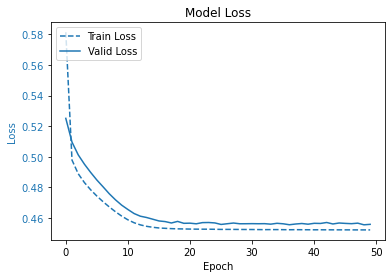

In [193]:
plot_loss(history)

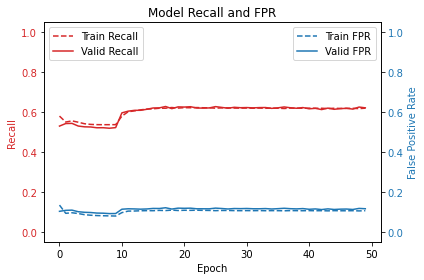

In [194]:
plot_model_recall_fpr(history)

In [195]:
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
preds = mlp.predict(scaled_val_in[:nval]).reshape(scaled_val_in[:nval].shape[0]) # scaled_val_in.mean(axis=(1,2,3)).reshape(199399,1))
binary_preds = np.where(preds >= binary_threshold, 1, 0)

In [196]:
# Example regressed metrics
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))

RMSE: 0.386
R squared: 0.378
Hellenger Distance: 0.687
Heidke Skill Score: 0.524
Pierce Skill Score: 0.506
Brier Score: 0.22
Brier Skill Score: 0.081
AUC: 0.753


... ah well ...

### Dense NN using lower-resolution patches

In [42]:
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

In [43]:
%%time
lowres_patch = 4
lowres_train_in = np.zeros((train_in.shape[0],lowres_patch,lowres_patch,nchannels))
for i in range(train_in.shape[0]):
    for k in range(nchannels):
        lowres_train_in[i,:,:,k] = rebin(train_in[i,:,:,k], (lowres_patch, lowres_patch))

CPU times: user 21.3 s, sys: 495 ms, total: 21.8 s
Wall time: 21.1 s


In [44]:
%%time
lowres_val_in = np.zeros((val_in.shape[0],lowres_patch,lowres_patch,nchannels))
for i in range(val_in.shape[0]):
    for k in range(nchannels):
        lowres_val_in[i,:,:,k] = rebin(val_in[i,:,:,k], (lowres_patch, lowres_patch))

CPU times: user 20.1 s, sys: 431 ms, total: 20.5 s
Wall time: 19.7 s


In [45]:
%%time
# use standard scaler, since this gave better results yesterday
scaler = StandardScaler()
scaled_train_in = scaler.fit_transform(lowres_train_in.reshape(lowres_train_in.shape[0],lowres_patch*lowres_patch*nchannels))#.reshape(lowres_train_in.shape[0],lowres_patch,lowres_patch,nchannels)
scaled_val_in = scaler.fit_transform(lowres_val_in.reshape(lowres_val_in.shape[0],lowres_patch*lowres_patch*nchannels))#.reshape(lowres_val_in.shape[0],lowres_patch,lowres_patch,nchannels)

CPU times: user 531 ms, sys: 157 ms, total: 688 ms
Wall time: 682 ms


In [46]:
scaled_train_in.shape

(212604, 64)

In [47]:
mlp = Sequential()
mlp.add(Input(shape=scaled_train_in.shape[1:]))
mlp.add(Dense(32, activation='relu'))
mlp.add(Dense(16, activation='relu'))
mlp.add(Dense(8, activation='relu'))
mlp.add(Dense(4, activation='relu'))
mlp.add(Dense(2, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))
mlp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 3         
Total params: 2,793
Trainable params: 2,793
Non-trainable params: 0
____________________________________________________

In [48]:
mlp.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Recall(), FalsePositiveRate()]
           )

In [49]:
%%time
ntrain = scaled_train_in.shape[0]
nval   = scaled_val_in.shape[0]
history = mlp.fit(x=scaled_train_in[:ntrain],
                  y=train_out[:ntrain],
                  batch_size=512,
                  epochs=50,
                  validation_data=(scaled_val_in[:nval], val_out[:nval]),
                  verbose=1).history

Epoch 1/50
416/416 [==============================] - 3s 8ms/step - loss: 0.3916 - accuracy: 0.8274 - recall_1: 0.6894 - false_positive_rate: 0.0933 - val_loss: 0.3533 - val_accuracy: 0.8452 - val_recall_1: 0.7798 - val_false_positive_rate: 0.1120
Epoch 2/50
416/416 [==============================] - 3s 7ms/step - loss: 0.3237 - accuracy: 0.8659 - recall_1: 0.7999 - false_positive_rate: 0.0961 - val_loss: 0.3413 - val_accuracy: 0.8552 - val_recall_1: 0.7809 - val_false_positive_rate: 0.0962
Epoch 3/50
416/416 [==============================] - 3s 7ms/step - loss: 0.3132 - accuracy: 0.8712 - recall_1: 0.8131 - false_positive_rate: 0.0953 - val_loss: 0.3388 - val_accuracy: 0.8582 - val_recall_1: 0.8006 - val_false_positive_rate: 0.1042
Epoch 4/50
416/416 [==============================] - 3s 7ms/step - loss: 0.3060 - accuracy: 0.8742 - recall_1: 0.8171 - false_positive_rate: 0.0929 - val_loss: 0.3360 - val_accuracy: 0.8589 - val_recall_1: 0.7746 - val_false_positive_rate: 0.0860
Epoch 5/

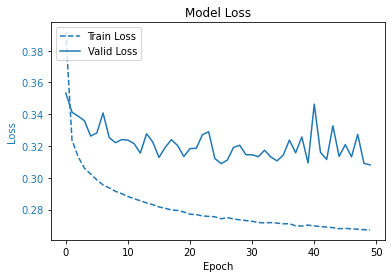

In [50]:
plot_loss(history)

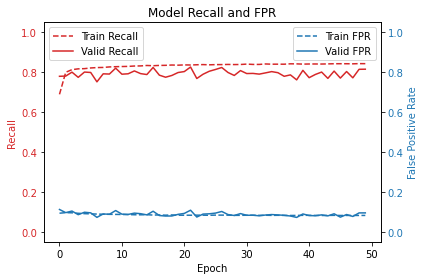

In [51]:
plot_model_recall_fpr(history)

In [52]:
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
preds = mlp.predict(scaled_val_in[:nval]).reshape(scaled_val_in[:nval].shape[0]) # scaled_val_in.mean(axis=(1,2,3)).reshape(199399,1))
binary_preds = np.where(preds >= binary_threshold, 1, 0)

In [53]:
# Example regressed metrics
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))

RMSE: 0.308
R squared: 0.603
Hellenger Distance: 0.452
Heidke Skill Score: 0.725
Pierce Skill Score: 0.72
Brier Score: 0.13
Brier Skill Score: 0.454
AUC: 0.86


### Wednesday
* Calculate three relevant evaluation metrics for each ML solution and baseline
* Refine machine learning approaches and test additional hyperparameter settings

### Helper functions

In [9]:
def plot_loss(model_history):
    train_loss=[value for key, value in model_history.items() if 'loss' in key.lower()][0]
    valid_loss=[value for key, value in model_history.items() if 'loss' in key.lower()][1]
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color=color)
    ax1.set_ylim([-0.05,1.05])
    ax1.plot(train_loss, '--', color=color, label='Train Loss')
    ax1.plot(valid_loss, color=color, label='Valid Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    plt.legend(loc='upper left')
    plt.title('Model Loss')
    plt.show()
    
def plot_model_recall_fpr(model_history):
    train_recall=[value for key, value in model_history.items() if 'recall' in key.lower()][0]
    valid_recall=[value for key, value in model_history.items() if 'recall' in key.lower()][1]
    train_fpr=[value for key, value in model_history.items() if 'false_positive_rate' in key.lower()][0]
    valid_fpr=[value for key, value in model_history.items() if 'false_positive_rate' in key.lower()][1]
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('POD', color=color)
    ax1.set_ylim([-0.05,1.05])
    ax1.plot(train_recall, '--', color=color, label='Train POD')
    ax1.plot(valid_recall, color=color, label='Valid POD')
    ax1.tick_params(axis='y', labelcolor=color)
    plt.legend(loc='upper left')
    plt.title('Model Recall (POD) and False Positive Rate (FAR)')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('FAR', color=color)  # we already handled the x-label with ax1
    ax2.plot(train_fpr, '--', color=color, label='Train FAR')
    ax2.plot(valid_fpr, color=color, label='Valid FAR')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([-0.05,1.05])
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.legend(loc='upper right')
    plt.show()

class FalsePositiveRate(tf.keras.metrics.Metric):
    def __init__(self, name='false_positive_rate', **kwargs):
        super(FalsePositiveRate, self).__init__(name=name, **kwargs)
        self.negatives = self.add_weight(name='negatives', initializer='zeros')
        self.false_positives = self.add_weight(name='false_negatives', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        '''
        Arguments:
        y_true  The actual y. Passed by default to Metric classes.
        y_pred  The predicted y. Passed by default to Metric classes.
        
        '''
        # Compute the number of negatives.
        y_true = tf.cast(y_true, tf.bool)
        
        negatives = tf.reduce_sum(tf.cast(tf.equal(y_true, False), self.dtype))
        
        self.negatives.assign_add(negatives)
        
        # Compute the number of false positives.
        y_pred = tf.greater_equal(y_pred, 0.5)  # Using default threshold of 0.5 to call a prediction as positive labeled.
        
        false_positive_values = tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True)) 
        false_positive_values = tf.cast(false_positive_values, self.dtype)
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self.dtype)
            sample_weight = tf.broadcast_weights(sample_weight, values)
            values = tf.multiply(false_positive_values, sample_weight)
        
        false_positives = tf.reduce_sum(false_positive_values)
        
        self.false_positives.assign_add(false_positives)
        
    def result(self):
        return tf.divide(self.false_positives, self.negatives)


In [10]:
# Metric functions
from sklearn.metrics import confusion_matrix, mean_squared_error, brier_score_loss, roc_auc_score

import numpy as np

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def auc_score(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def brier_score(y_true, y_pred):
    return brier_score_loss(y_true, y_pred)

def brier_skill_score(y_true, y_pred):
    
    model_brier_score = mean_squared_error(y_true, y_pred)
    climo_brier_score = mean_squared_error(y_true, np.ones(y_true.size) * y_true.sum() / y_true.size)
    model_brier_skill_score = 1 - model_brier_score / climo_brier_score
    return model_brier_skill_score

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def peirce_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (no * no).sum() / n ** 2)

def heidke_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (nf * no).sum() / n ** 2)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

def perf_measure(y_true, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_true)): 
        if y_true[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_true[i]!=y_pred[i]:
           FN += 1
    # Sensitivity, hit rate, recall, or true positive rate, or probability of detection
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate or false alarm ratio
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    return {
        'TP'  : TP,
        'FP'  : FP,
        'TN'  : TN,
        'FN'  : FN,
        'TPR' : TPR,
        'TNR' : TNR,
        'PPV' : PPV,
        'NPV' : NPV,
        'FPR' : FPR,
        'FNR' : FNR,
        'FDR' : FDR,
        'ACC' : ACC,
        }

In [11]:
nsamples_train = train_in.shape[0]
nx = train_in.shape[1]
ny = train_in.shape[2]
nchannels = train_in.shape[3]
print(nsamples_train, nx, ny, nchannels)

212604 32 32 4


In [12]:
nsamples_val = val_in.shape[0]
#nx = val_in.shape[1]
#ny = val_in.shape[2]
#nchannels = val_in.shape[3]
print(nsamples_val, nx, ny, nchannels)

199399 32 32 4


### Combine the dense neural network with a PCA

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, AlphaDropout, Conv2D, MaxPooling2D, Flatten
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [28]:
%%time
scaler = StandardScaler()
scaled_train_in = scaler.fit_transform(train_in.reshape(nsamples_train,nx*ny*nchannels))#.reshape(lowres_train_in.shape[0],lowres_patch,lowres_patch,nchannels)
scaled_val_in = scaler.fit_transform(val_in.reshape(nsamples_val,nx*ny*nchannels))#.reshape(lowres_val_in.shape[0],lowres_patch,lowres_patch,nchannels)
print(scaled_train_in.shape)

(212604, 4096)
CPU times: user 34 s, sys: 6.64 s, total: 40.7 s
Wall time: 40.5 s


In [29]:
# Data dimension reduction.
pca = PCA(n_components=32)

In [30]:
%%time
pca_train_in = pca.fit_transform(X=scaled_train_in)
pca_val_in = pca.transform(X=scaled_val_in)

CPU times: user 1min 24s, sys: 1.66 s, total: 1min 25s
Wall time: 27.7 s


(212604, 32)
(212604,)
(199399, 32)
(199399,)


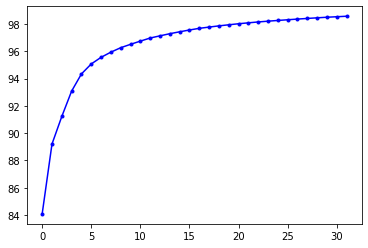

In [31]:
# Cumulative explained variance ratio.
plt.plot(np.cumsum(pca.explained_variance_ratio_*100), ".-b")
print(pca_train_in.shape)
print(train_out.shape)
print(pca_val_in.shape)
print(val_out.shape)

In [32]:
do_selu = False
if do_selu:
    mlp = Sequential()
    mlp.add(Input(shape=pca_train_in.shape[1:]))
    mlp.add(Dense(16, kernel_initializer='lecun_normal', activation='selu'))
    mlp.add(Dense(8, kernel_initializer='lecun_normal', activation='selu'))
    mlp.add(AlphaDropout(0.1))
    mlp.add(Dense(4, kernel_initializer='lecun_normal', activation='selu'))
    mlp.add(Dense(2, kernel_initializer='lecun_normal', activation='selu'))
    mlp.add(Dense(1, activation='sigmoid'))
    mlp.summary()
else:
    mlp = Sequential()
    mlp.add(Input(shape=pca_train_in.shape[1:]))
    mlp.add(Dense(16, activation='relu'))
    mlp.add(Dense(8, activation='relu'))
    mlp.add(Dense(4, activation='relu'))
    mlp.add(Dense(2, activation='relu'))
    mlp.add(Dense(1, activation='sigmoid'))
    mlp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 3         
Total params: 713
Trainable params: 713
Non-trainable params: 0
_________________________________________________________________


In [33]:
mlp.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Recall(), FalsePositiveRate()]
           )

In [34]:
%%time
history = mlp.fit(x=pca_train_in[:nsamples_train],
                  y=train_out[:nsamples_train],
                  batch_size=512,
                  epochs=50,
                  validation_data=(pca_val_in[:nsamples_val], val_out[:nsamples_val]),
                  verbose=1).history

Epoch 1/50
416/416 [==============================] - 3s 7ms/step - loss: 0.5507 - accuracy: 0.6897 - recall_1: 0.2908 - false_positive_rate: 0.0825 - val_loss: 0.4077 - val_accuracy: 0.7764 - val_recall_1: 0.5794 - val_false_positive_rate: 0.0949
Epoch 2/50
416/416 [==============================] - 3s 7ms/step - loss: 0.3714 - accuracy: 0.8257 - recall_1: 0.6702 - false_positive_rate: 0.0849 - val_loss: 0.3679 - val_accuracy: 0.8277 - val_recall_1: 0.7077 - val_false_positive_rate: 0.0939
Epoch 3/50
416/416 [==============================] - 3s 7ms/step - loss: 0.3414 - accuracy: 0.8489 - recall_1: 0.7420 - false_positive_rate: 0.0896 - val_loss: 0.3528 - val_accuracy: 0.8412 - val_recall_1: 0.7575 - val_false_positive_rate: 0.1042
Epoch 4/50
416/416 [==============================] - 3s 7ms/step - loss: 0.3303 - accuracy: 0.8567 - recall_1: 0.7638 - false_positive_rate: 0.0898 - val_loss: 0.3462 - val_accuracy: 0.8472 - val_recall_1: 0.7746 - val_false_positive_rate: 0.1054
Epoch 5/

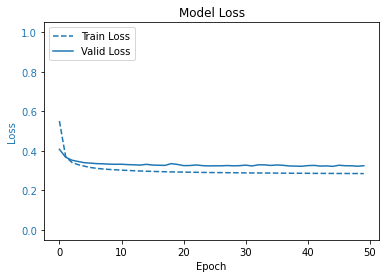

In [35]:
plot_loss(history)

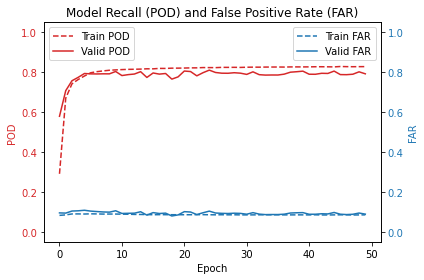

In [36]:
plot_model_recall_fpr(history)

In [37]:
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
preds = mlp.predict(pca_val_in[:nsamples_val]).reshape(pca_val_in[:nsamples_val].shape[0]) # scaled_val_in.mean(axis=(1,2,3)).reshape(199399,1))
binary_preds = np.where(preds >= binary_threshold, 1, 0)

In [38]:
# Example regressed metrics
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))
performance = perf_measure(val_out, binary_preds)
print('Probability of detection: {}'.format(np.round(performance['TPR'],3)))
print('False alarm ratio: {}'.format(np.round(performance['FPR'],3)))
print('Accuracy: {}'.format(np.round(performance['ACC'],3)))

RMSE: 0.316
R squared: 0.584
Hellenger Distance: 0.462
Heidke Skill Score: 0.712
Pierce Skill Score: 0.704
Brier Score: 0.136
Brier Skill Score: 0.432
AUC: 0.852
Probability of detection: 0.792
False alarm ratio: 0.089
Accuracy: 0.864


### CNN

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, AlphaDropout, Conv2D, MaxPooling2D, Flatten
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [14]:
%%time
scaler = StandardScaler()
scaled_train_in = scaler.fit_transform(train_in.reshape(nsamples_train,nx*ny*nchannels)).reshape(nsamples_train,nx,ny,nchannels)
scaled_val_in = scaler.fit_transform(val_in.reshape(nsamples_val,nx*ny*nchannels)).reshape(nsamples_val,nx,ny,nchannels)
print(scaled_train_in.shape)

(212604, 32, 32, 4)
CPU times: user 33.8 s, sys: 7.35 s, total: 41.1 s
Wall time: 41 s


In [15]:
mlp = Sequential()
mlp.add(Input(shape=scaled_train_in.shape[1:]))
mlp.add(Conv2D(8, (3, 3), activation='relu'))
mlp.add(MaxPooling2D(2, 2))
mlp.add(Conv2D(8, (3, 3), activation='relu'))
mlp.add(MaxPooling2D(2, 2))
mlp.add(Conv2D(8, (3, 3), activation='relu'))
mlp.add(MaxPooling2D(2, 2))
mlp.add(Flatten())
mlp.add(Dense(16, activation='relu'))
mlp.add(Dense(1, activation='sigmoid'))
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 8)         296       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0

In [16]:
mlp.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Recall(), FalsePositiveRate()]
           )

In [17]:
%%time
history = mlp.fit(x=scaled_train_in[:nsamples_train],
                  y=train_out[:nsamples_train],
                  batch_size=512,
                  epochs=25,
                  validation_data=(scaled_val_in[:nsamples_val],
                                   val_out[:nsamples_val]),
                  verbose=1).history

Epoch 1/25
416/416 [==============================] - 29s 70ms/step - loss: 0.3580 - accuracy: 0.8510 - recall: 0.7763 - false_positive_rate: 0.1061 - val_loss: 0.3266 - val_accuracy: 0.8614 - val_recall: 0.7774 - val_false_positive_rate: 0.0837
Epoch 2/25
416/416 [==============================] - 10s 24ms/step - loss: 0.2795 - accuracy: 0.8850 - recall: 0.8366 - false_positive_rate: 0.0872 - val_loss: 0.3103 - val_accuracy: 0.8689 - val_recall: 0.7807 - val_false_positive_rate: 0.0735
Epoch 3/25
416/416 [==============================] - 10s 24ms/step - loss: 0.2627 - accuracy: 0.8925 - recall: 0.8520 - false_positive_rate: 0.0843 - val_loss: 0.2917 - val_accuracy: 0.8788 - val_recall: 0.8271 - val_false_positive_rate: 0.0873
Epoch 4/25
416/416 [==============================] - 10s 24ms/step - loss: 0.2565 - accuracy: 0.8955 - recall: 0.8586 - false_positive_rate: 0.0833 - val_loss: 0.3147 - val_accuracy: 0.8686 - val_recall: 0.7494 - val_false_positive_rate: 0.0535
Epoch 5/25
416/4

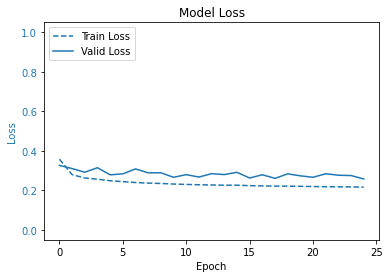

In [18]:
plot_loss(history)

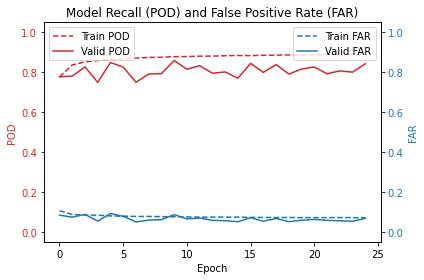

In [19]:
plot_model_recall_fpr(history)

In [20]:
# set the probability threshold for binary classification; predict on validation; add binary preds
binary_threshold = 0.5
preds = mlp.predict(scaled_val_in[:nsamples_val]).reshape(scaled_val_in[:nsamples_val].shape[0])
binary_preds = np.where(preds >= binary_threshold, 1, 0)

In [21]:
# Example regressed metrics
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))
performance = perf_measure(val_out, binary_preds)
print('Probability of detection: {}'.format(np.round(performance['TPR'],3)))
print('False alarm ratio: {}'.format(np.round(performance['FPR'],3)))
print('Accuracy: {}'.format(np.round(performance['ACC'],3)))

RMSE: 0.278
R squared: 0.681
Hellenger Distance: 0.369
Heidke Skill Score: 0.782
Pierce Skill Score: 0.775
Brier Score: 0.103
Brier Skill Score: 0.569
AUC: 0.888
Probability of detection: 0.843
False alarm ratio: 0.068
Accuracy: 0.897


In [24]:
%%time

from sklearn.preprocessing import StandardScaler, RobustScaler

# Scale train data by Standard scaler.
old_shape_train = train_in.shape
new_shape_train = (old_shape_train[0], -1)
scaler = RobustScaler().fit(X=train_in.reshape(*new_shape_train))
scaled_train_in_reshaped = scaler.transform(X=train_in.reshape(*new_shape_train))

# Scale validation data using Standard scaler fit on training data.
old_shape_val = val_in.shape
new_shape_val = (old_shape_val[0], -1)
scaled_val_in_reshaped = scaler.transform(X=val_in.reshape(*new_shape_val))

CPU times: user 1min 11s, sys: 1.41 s, total: 1min 13s
Wall time: 1min 12s


CPU times: user 1min 17s, sys: 2.81 s, total: 1min 19s
Wall time: 26.2 s


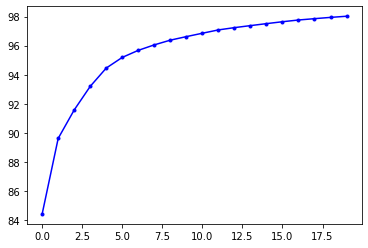

In [25]:
%%time

from sklearn.decomposition import PCA

# Data dimension reduction.
n_components = 20
pca = PCA(n_components=n_components)
scaled_train_in_reshaped_reduced = pca.fit_transform(X=scaled_train_in_reshaped)
scaled_val_in_reshaped_reduced = pca.transform(X=scaled_val_in_reshaped)

# Cumulative explained variance ratio.
plt.plot(np.cumsum(pca.explained_variance_ratio_*100), ".-b")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 928       
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 969
Trainable params: 969
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
1661/1661 [==============================] - 10s 6ms/step - loss: 0.3983 - accuracy: 0.8385 - val_loss: 0.3412 - val_accuracy: 0.8652
Epoch 2/50
1661/1661 [==============================] - 10s 6ms/step - loss: 0.3082 - accuracy: 0.8820 - val_loss: 0.3243 - val_accuracy: 0.8743
Epoch 3/50
1661/1661 [

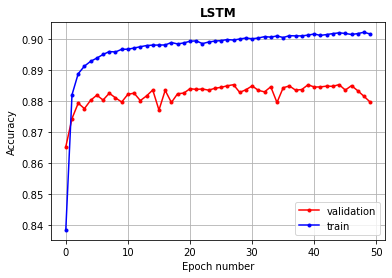

In [28]:
%%time

import tensorflow as tf
tf.keras.backend.clear_session()

# (ti, ti+1, ti+2) are used to predict ti+3.
n_features = n_components # From pca.
window_size = 3
batch_size= 128
time_steps = scaled_train_in_reshaped_reduced.shape[0]

# Utility class for generating batches of temporal training data.
dg_train = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    data=scaled_train_in_reshaped_reduced,
    targets=train_out,
    length=window_size,
    sampling_rate=1,
    stride=1,
    batch_size=batch_size
)

# Utility class for generating batches of temporal validation data.
dg_val = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    data=scaled_val_in_reshaped_reduced,
    targets=val_out,
    length=window_size,
    sampling_rate=1,
    stride=1,
    batch_size=batch_size
)

# LSTM architecture.
model = model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=(time_steps, n_features)),
    tf.keras.layers.Dense(4, activation="tanh"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Model architecture.
model.summary()

# Prepare for training.
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Train!
history = model.fit_generator(
    generator=dg_train, 
    epochs=50, 
    verbose=1,
    validation_data=dg_val
)

# Accuracy as function of epochs.
plt.plot(history.history["val_accuracy"], ".-r", label="validation")
plt.plot(history.history["accuracy"],  ".-b", label="train")
plt.xlabel("Epoch number")
plt.ylabel("Accuracy")
plt.title("LSTM", weight="bold")
plt.legend()
plt.grid()

# Set the probability threshold for binary classification.
# Predict on validation. 
# Add binary preds.
binary_threshold = 0.5
preds = model.predict(x=dg_val).reshape((-1, ))
binary_preds = np.where(preds >= binary_threshold, 1, 0)

print("\n>>> LSTM")

# Example regressed metrics
print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out[window_size:], preds),3)))
print('R squared: {}'.format(np.round(r2_corr(val_out[window_size:], preds),3)))
print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out[window_size:], preds),3)))

# Example classified metrics
print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out[window_size:], binary_preds),3)))
print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out[window_size:], binary_preds),3)))
print('Brier Score: {}'.format(np.round(brier_score(val_out[window_size:], binary_preds),3)))
print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out[window_size:], binary_preds),3)))
print('AUC: {}'.format(np.round(roc_auc_score(val_out[window_size:], binary_preds),3)))

### Thursday 
* Evaluate two interpretation methods for your machine learning solution
* Compare interpretation of baseline with your approach
* Submit best results on project to leaderboard
* Prepare 2 Google Slides on team's approach and submit them 

In [ ]:
# Thursday's code goes here


## Ultimate Submission Code
Please insert your full data processing and machine learning pipeline code in the cell below.